cvt_florida.ipynb

Discussion: Compute a CVT using the shape of the state of Florida.

Licensing: This code is distributed under the GNU LGPL license.
    
Modified: 10 November 2016

Author: John Burkardt, Lukas Bystricky

In [1]:
# Import necessary libraries and set plot option
%matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.spatial as spatial

Using matplotlib backend: agg


# A CVT of Florida #

We can approximate the shape of Florida using a polygon, whose
vertices are given as longitude and latitude values.  Then we
can pick the locations of a few Florida cities as initial generators and
apply our CVT iteration.  

We will look at:
* how to read a file containing polygon information, and display it.
* another way to determine if a point is in a polygon.
* another way to uniformly randomly sample a polygon.
* how to use the longitude and latitude of some Florida cities as starting generators.
* how to compute one step of the CVT;
* how to run the CVT and display the final configuration.

# Longitude and Latitudes for Florida Polygon Vertices#

The file "florida_shape.txt" is available from the web page 
http://people.sc.fsu.edu/~jburkardt/classes/urop_2016/urop_2016.html

The Florida polygon consists of 570 vertices.  The data file lists the
longitude and latitude of each vertex, which you can treat as though
these were X and Y coordinates.  The file repeats the first line as the
last line (#571) which is a plus if you are drawing the polygon.

We need to read this file, and make a plot of the points to convince ourselves
that we read it correctly.

    0  -81.5000   30.7200
    1  -81.4800   30.6800
    2  -81.4500   30.7000
    3  -81.4300   30.6800
    4  -81.4500   30.5700
    5  -81.4300   30.5200
    6  -81.4700   30.5500
    7  -81.4800   30.6200
    8  -81.5000   30.6200
    9  -81.5000   30.5500
...
  560  -81.7800   30.7700
  561  -81.7300   30.7700
  562  -81.7200   30.7500
  563  -81.6800   30.7300
  564  -81.6500   30.7300
  565  -81.6300   30.7300
  566  -81.6200   30.7200
  567  -81.5500   30.7000
  568  -81.5200   30.7200
  569  -81.5000   30.7200


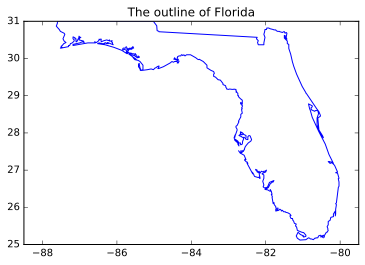

In [2]:
# Code to read and display longitude and latitude for Florida polygon vertices

def florida_shape_read ( ):

  import numpy as np

  input = open ( 'florida_shape.txt', 'r' )

  lon = np.zeros ( 570 )
  lat = np.zeros ( 570 )

  i = 0
  for line in input:

    if ( line[0] == '#' ):
      continue
    else:
      data = line.split ( )
      lon[i] = data[0]
      lat[i] = data[1]
      i = i + 1

  input.close ( )

  return lon, lat
#
#  Test the function.
#
lon, lat = florida_shape_read ( )
for i in range ( 0, 10 ):
  print ( '  %3d  %8.4f  %8.4f' % ( i, lon[i], lat[i] ) ) 
print ( '...')
for i in range ( 560, 570 ):
  print ( '  %3d  %8.4f  %8.4f' % ( i, lon[i], lat[i] ) ) 

plt.plot ( lon, lat, 'b-' )
plt.axis ( 'Equal')
plt.title ( 'The outline of Florida')

# Polygon contains point? #

In the polygon notebook, we showed that we used triangulation
to determine if a polygon contained a point.  When dealing with
Florida, we will prefer another method, which is made available to
you in a Python file:
    
http://people.sc.fsu.edu/~jburkardt/classes/urop_2016/polygon_contains_point.py
    
You should copy this and put it in the same directory as your notebook,
and invoke it using the command

    from polygon_contains_point import polygon_contains_point
    
The function has the form
```python
def polygon_contains_point ( x, y, px, py ):
  ***
  return inside
```
where the point is (x,y), the coordinates of the vertices of the 
polygon are in the arrays px and py, and the result "inside" is 
True if the polygon contains the point.

Test this function using the florida longitude and latitude data
for the polygon coordinates px and py, and the following points:
    
    Point  Lon     Lat  Where?
      0    -87     26   (In the ocean!)
      1    -81     30   (In the ocean!)
      2    -84     30.5 (Near Tallahassee
      3    -81     26   (Near Miami)

In [3]:
# Test code for polygon contains point #

from polygon_contains_point import polygon_contains_point

x = np.array ( [ -87.0, -81.0, -84.0, -81.0 ] )
y = np.array ( [  26.0,  30.0,  30.5,  26.0 ] )

for i in range ( 0, 4 ):
  inside = polygon_contains_point ( x[i], y[i], lon, lat )
  print ( '  %2d  %8.4f  %8.4f  %s' % ( i, x[i], y[i], inside ) )

   0  -87.0000   26.0000  False
   1  -81.0000   30.0000  False
   2  -84.0000   30.5000  True
   3  -81.0000   26.0000  True


# Acceptance/Rejection Sampling of the Florida Polygon #

In the polygon notebook, we showed that we could use triangulation
to sample the polygon uniformly.  But because Florida is a complicated
polygon, we will try a simpler method. 

To get a uniformly random point from Florida:
* Surround Florida by a rectangular box;
* Get a random point in that box (easy);
* If the Florida polygon does not contain that point, go back one step;

A box that contains Florida has the lower left corner (-88,25) and
the upper right corner (-80,31).

To get a sample point, then, we get unit random numbers r1 and r2 and 
compute:

    x = -88 + 8 * r1
    y =  25 + 6 * r2

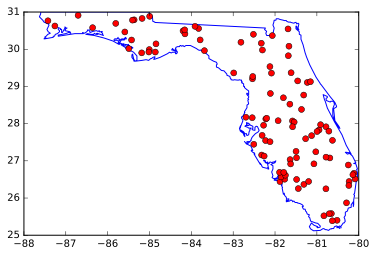

In [4]:
# Code for acceptance/rejection sampling of the Florida Polygon

def florida_sample ( m ):
  xy = np.zeros ( [ m, 2 ] )
  i = 0
  while ( i < m ):
    r1 = np.random.rand ( )
    r2 = np.random.rand ( )
    x = -88.0 + 8.0 * r1
    y =  25.0 + 6.0 * r2
    inside = polygon_contains_point ( x, y, lon, lat )
    if ( inside ):
      xy[i,0] = x
      xy[i,1] = y
      i = i + 1
  return xy
#
#  Test the code.
#
m = 100
xy = florida_sample ( m )
plt.plot ( lon, lat, 'b-' )
plt.plot ( xy[:,0], xy[:,1], 'ro' )

# CVT step for Florida #

Now we can write the CVT step for Florida.

Given N current generators G, and using M sample points, we want to
estimate the N centroids C of the corresponding Voronoi regions.

Use the following seven Florida cities for G:

    -87.20, 30.43  Pensacola
    -84.25, 30.46  Tallahassee
    -81.66, 30.34  Jacksonville
    -82.48, 27.97  Tampa
    -82.32, 29.65  Gainesville
    -81.30, 28.42  Orlando
    -80.21, 25.78  Miami

In [5]:
#  cvt_step_florida()
#
def cvt_step_florida ( g, m ):
  import numpy as np
  n = g.shape[0]
  s = florida_sample ( m )
  ni = np.zeros ( n )
  c = np.zeros ( [ n, 2 ])
  for i in range ( 0, m ):
    k = -1
    d = np.Inf
    for j in range ( 0, n ):
      dj = np.linalg.norm ( s[i,:] - g[j,:] )
      if ( dj < d ):
        d = dj
        k = j
    ni[k] = ni[k] + 1
    c[k,:] = c[k,:] + s[i,:]
    
  for i in range ( 0, n ):
    c[i,:] = c[i,:] / float ( ni[i] )
    
  return c
#
#  Test the function using 7 Florida cities to start with.
#
import numpy as np
g = np.array ( [ \
  [ -87.20, 30.43 ], \
  [ -84.25, 30.46 ], \
  [ -81.66, 30.34 ], \
  [ -82.48, 27.97 ], \
  [ -82.32, 29.65 ], \
  [ -81.30, 28.42 ], \
  [ -80.21, 25.78 ] ] )

m = 1000
c = cvt_step_florida ( g, m )
print ( c )

[[-86.61426552  30.71168878]
 [-84.54031681  30.32754013]
 [-81.70440116  30.21489764]
 [-82.12693031  27.66841477]
 [-82.50193766  29.61688588]
 [-81.17685053  28.12548008]
 [-80.83812526  26.16262678]]


# CVT Iteration for Florida #

Once we have a CVT step function, the CVT iteration is easy.  Try taking 10 steps,
and plot the locations of G before the iteration, and then at the end.

You may also be able to plot the Voronoi diagram on top of the plot of the cities.

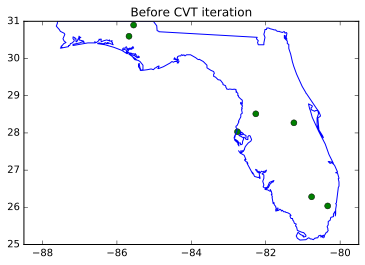

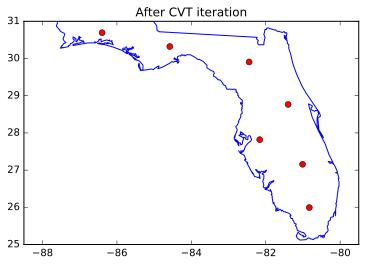

In [8]:
# Code for CVT Iteration for Florida
#
def cvt_florida ( n, m, step_num ):

  g = florida_sample ( n )

# vor = spatial.Voronoi ( g )
# spatial.voronoi_plot_2d ( vor )
  plt.plot ( g[:,0], g[:,1], 'go' )
  plt.plot ( lon, lat, 'b-' )
  plt.axis ( 'Equal' )
  plt.title ( 'Before CVT iteration')
  plt.show ( )

  for step in range ( 0, step_num ):
    c = cvt_step_florida ( g, m )
    g = c.copy ( )
  return g
#
#  Test the code.
#
n = 7
m = 5000
step_num = 10
g = cvt_florida ( n, m, step_num )

#vor = spatial.Voronoi ( g )
#spatial.voronoi_plot_2d ( vor )
plt.plot ( g[:,0], g[:,1], 'ro' )
plt.plot ( lon, lat, 'b-' )
plt.axis ( 'Equal' )
plt.title ( 'After CVT iteration')
plt.show ( )